In [58]:
!brew install ffmpeg

14328.94s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
==> Downloading https://ghcr.io/v2/homebrew/portable-ruby/portable-ruby/blobs/sha256:d783cbeb6e6ef0d71c0b442317b54554370decd6fac66bf2d4938c07a63f67be
######################################################################### 100.0%                                    2.1%                                                 6.0%                                           8.7%                                          10.7%                                                   11.0%                                          11.4%                                                  12.8%                                                 13.9%                             14.6% 14.7%                                            15.7%                                   17.1%                                           17.2%                20.7%                               20.8%                                         

# Import Required Packages

In [213]:
import os
from os import listdir
from pathlib import Path

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

import itertools
import glob
import random

from IPython.display import Audio, Image
from scipy.io import wavfile
from os.path import isdir, join

import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn

from tqdm import tqdm

import tensorflow_datasets as tfds

from pydub import AudioSegment
from pydub.playback import play
import soundfile as sf

import typing as T

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.15.0


In [60]:
ds = tfds.load('speech_commands',
                     split=['train', 'validation'], 
                     data_dir='dataset')

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

In [64]:
!tar -xzf "dataset/downloads/down.tens.org_spee_comm_test_set_v0.2zCoAwRR8IlTpvj-g93nYwXQh3DSbhjZlZ6jt-prNUd8.tar.gz" -C "dataset/downloads/extracted"
!tar -xzf "dataset/downloads/down.tens.org_spee_comm_test_set_v0.2zCoAwRR8IlTpvj-g93nYwXQh3DSbhjZlZ6jt-prNUd8.tar.gz.INFO" -C "dataset/downloads/extracted"
!tar -xzf "dataset/downloads/downloa.tensorf.org_speech_command_v0.2rxRznufcMRRx3pj1-dLJGRsYrt_pV_Sm_3kccJho_1g.tar.gz" -C "dataset/downloads/extracted"
!tar -xzf "dataset/downloads/downloa.tensorf.org_speech_command_v0.2rxRznufcMRRx3pj1-dLJGRsYrt_pV_Sm_3kccJho_1g.tar.gz.INFO" -C "dataset/downloads/extracted"

39715.94s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
39722.30s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
tar: Error opening archive: Unrecognized archive format
39727.47s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
39760.03s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
tar: Error opening archive: Unrecognized archive format


In [66]:
background_noise_base_dir = "dataset/downloads/extracted/_background_noise_"
background_noise_path = Path(background_noise_base_dir).rglob("*.wav")

for background_noise_audio in background_noise_path:
  # Load the file

  file_name = background_noise_audio.stem
  audio, sr = librosa.load(background_noise_audio, sr=None)

  # Split the file by second

  for i in range(int(len(audio)/sr)):
    sf.write(f"{background_noise_base_dir}/{file_name}_{i}.wav", audio[(i*sr):(i+1)*sr], sr)

  # Remove the original file since it is not useful anymore

  os.system(f"rm {background_noise_audio}")

In [67]:
dataset_path = 'dataset/downloads/extracted'

# Create an all targets list
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]

# Sort the files because `listdir` always changes the order of listed files

all_targets.sort()

print(all_targets)

['_background_noise_', '_silence_', '_unknown_', 'backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [68]:
# Settings

target_list = all_targets
feature_sets_file = 'all_targets_mfcc_sets.npz'
sample_rate = 16000 # Hz
num_mfcc = 16

# number of frames
len_mfcc = 28

In [95]:
num_samples = 0
real = ['on','off','up','down']
all_targets = real
all_targets
for target in all_targets:
    num_samples += len(listdir(join(dataset_path, target)))
print('Total samples:', num_samples)

Total samples: 15230


In [99]:
target_list

['_background_noise_',
 '_silence_',
 '_unknown_',
 'backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [137]:
# Create list of filenames along with ground truth vector (y)

filenames = []
y = []
i=0
for index, target in enumerate(all_targets):
    print(join(dataset_path, target), ", index ", index)
    for filename in listdir(join(dataset_path, target)):
        filenames.append(join(dataset_path, target, filename))
    # filenames.append(listdir(join(dataset_path, target)))
        # y.append(np.ones(len(filenames[i])) * index)
        y.append(index)

dataset/downloads/extracted/on , index  0
dataset/downloads/extracted/off , index  1
dataset/downloads/extracted/up , index  2
dataset/downloads/extracted/down , index  3


In [140]:
len(filenames) == len(y)

True

In [102]:
# Generate the dictionary

for target in all_targets:
    print(target.upper(), end = ",")

ON,OFF,UP,DOWN,

In [103]:
# Create extern constants

for w in all_targets:
  print(f"extern const char {w.upper()}[];")

extern const char ON[];
extern const char OFF[];
extern const char UP[];
extern const char DOWN[];


In [104]:
# Create constant strings

for w in all_targets:
  print(f"const char {w.upper()}[] = \"{w}\";")

const char ON[] = "on";
const char OFF[] = "off";
const char UP[] = "up";
const char DOWN[] = "down";


In [141]:
# Validation and test percentage

val_ratio = 0.1
test_ratio = 0.1

In [143]:

filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

In [144]:
# Calculate validation and test set sizes

val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)
print(f"Validation size {val_set_size}\ntTest set size {test_set_size}")

Validation size 1523
tTest set size 1523


In [145]:
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

In [151]:
filenames_train

('dataset/downloads/extracted/up/e0315cf6_nohash_2.wav',
 'dataset/downloads/extracted/down/9e075bf1_nohash_0.wav',
 'dataset/downloads/extracted/up/211b928a_nohash_2.wav',
 'dataset/downloads/extracted/up/27c24504_nohash_4.wav',
 'dataset/downloads/extracted/off/b308773d_nohash_4.wav',
 'dataset/downloads/extracted/off/96c66ab7_nohash_1.wav',
 'dataset/downloads/extracted/off/cdee383b_nohash_2.wav',
 'dataset/downloads/extracted/on/d21fd169_nohash_3.wav',
 'dataset/downloads/extracted/off/24befdb3_nohash_2.wav',
 'dataset/downloads/extracted/off/db9cd41d_nohash_0.wav',
 'dataset/downloads/extracted/up/50a7d406_nohash_1.wav',
 'dataset/downloads/extracted/down/c661be6e_nohash_1.wav',
 'dataset/downloads/extracted/up/152491bc_nohash_0.wav',
 'dataset/downloads/extracted/on/3589bc72_nohash_4.wav',
 'dataset/downloads/extracted/on/9b8a7439_nohash_0.wav',
 'dataset/downloads/extracted/down/cd671b5f_nohash_0.wav',
 'dataset/downloads/extracted/off/bbc30633_nohash_2.wav',
 'dataset/downloads

In [146]:
y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [163]:
def calc_mfcc(path: str, debug: bool = False) -> np.ndarray:
  """Creates a matrix of MFCCs from the given input file.
  
  Args:
    path: the path to the file to extract MFCCs from
    debug: whenever to print signal shape or sampling rate

  Returns:
    An ndarray of shape (n_mffc, n_frames)
  """

  signal, fs = librosa.load(path, sr=sample_rate)
  if debug:
    print(f"DEBUG (calc_mfcc): signal shape={signal.shape}, sampling rate={fs}")

  # By default, n_fft=2048, hop_length=512
  mfccs = librosa.feature.mfcc(y=signal, sr=fs, n_mfcc=num_mfcc, dct_type=2, norm='ortho',lifter=0,center=False)
  
  return mfccs

In [164]:
# TEST: Construct test set by computing MFCC of each WAV file

prob_cnt = 0
x_test = []
y_test = []
max_index_ = 100

for index, filename in enumerate(filenames_train):
    print(index, filename)
    # Stop after `max_index_` iteration
    if index >= max_index_:
        break
    
    # Create path from given filename and target item
    # path = join(dataset_path, 
    #             target_list[int(y_orig_train[index])], 
    #             filename)
    
    # Create MFCCs
    print("filename: ", filename)
    print(type(filename))
    mfccs = calc_mfcc(filename, debug=False)

    # Keep only the MFCCs with the correct number of frames
    if mfccs.shape[1] == len_mfcc:
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1

0 dataset/downloads/extracted/up/e0315cf6_nohash_2.wav
filename:  dataset/downloads/extracted/up/e0315cf6_nohash_2.wav
<class 'str'>
1 dataset/downloads/extracted/down/9e075bf1_nohash_0.wav
filename:  dataset/downloads/extracted/down/9e075bf1_nohash_0.wav
<class 'str'>
Dropped: 1 (16, 20)
2 dataset/downloads/extracted/up/211b928a_nohash_2.wav
filename:  dataset/downloads/extracted/up/211b928a_nohash_2.wav
<class 'str'>
3 dataset/downloads/extracted/up/27c24504_nohash_4.wav
filename:  dataset/downloads/extracted/up/27c24504_nohash_4.wav
<class 'str'>
4 dataset/downloads/extracted/off/b308773d_nohash_4.wav
filename:  dataset/downloads/extracted/off/b308773d_nohash_4.wav
<class 'str'>
5 dataset/downloads/extracted/off/96c66ab7_nohash_1.wav
filename:  dataset/downloads/extracted/off/96c66ab7_nohash_1.wav
<class 'str'>
6 dataset/downloads/extracted/off/cdee383b_nohash_2.wav
filename:  dataset/downloads/extracted/off/cdee383b_nohash_2.wav
<class 'str'>
7 dataset/downloads/extracted/on/d21fd1

In [165]:
print('% of problematic samples:', prob_cnt / max_index_)

% of problematic samples: 0.12


In [171]:
filenames_train

('dataset/downloads/extracted/up/e0315cf6_nohash_2.wav',
 'dataset/downloads/extracted/down/9e075bf1_nohash_0.wav',
 'dataset/downloads/extracted/up/211b928a_nohash_2.wav',
 'dataset/downloads/extracted/up/27c24504_nohash_4.wav',
 'dataset/downloads/extracted/off/b308773d_nohash_4.wav',
 'dataset/downloads/extracted/off/96c66ab7_nohash_1.wav',
 'dataset/downloads/extracted/off/cdee383b_nohash_2.wav',
 'dataset/downloads/extracted/on/d21fd169_nohash_3.wav',
 'dataset/downloads/extracted/off/24befdb3_nohash_2.wav',
 'dataset/downloads/extracted/off/db9cd41d_nohash_0.wav',
 'dataset/downloads/extracted/up/50a7d406_nohash_1.wav',
 'dataset/downloads/extracted/down/c661be6e_nohash_1.wav',
 'dataset/downloads/extracted/up/152491bc_nohash_0.wav',
 'dataset/downloads/extracted/on/3589bc72_nohash_4.wav',
 'dataset/downloads/extracted/on/9b8a7439_nohash_0.wav',
 'dataset/downloads/extracted/down/cd671b5f_nohash_0.wav',
 'dataset/downloads/extracted/off/bbc30633_nohash_2.wav',
 'dataset/downloads

MFCCs: [[-7.05752747e+02 -7.08402283e+02 -7.07070007e+02 -7.06333740e+02
  -7.05627014e+02 -6.92377258e+02 -4.33346924e+02 -2.65567780e+02
  -2.14751266e+02 -2.30884476e+02 -3.03135590e+02 -4.29405701e+02
  -5.14250061e+02 -5.59580078e+02 -5.94792969e+02 -5.47055237e+02
  -4.39663055e+02 -4.54967285e+02 -6.11501465e+02 -6.73671997e+02
  -6.84779663e+02 -6.97770508e+02 -7.06041016e+02 -7.03879822e+02
  -7.03020569e+02 -7.02771606e+02 -7.03691406e+02 -7.03892395e+02]
 [ 1.00436974e+01  7.57483864e+00  7.22575188e+00  7.05696917e+00
   9.64819336e+00  2.75674591e+01  1.98847137e+02  2.21032074e+02
   2.11751923e+02  2.15343048e+02  2.18168335e+02  2.08351746e+02
   1.80146683e+02  1.56275360e+02  1.27309769e+02  9.01570892e+01
   8.79550552e+01  8.66889801e+01  6.97601318e+01  3.27318954e+01
   2.73555756e+01  2.06768913e+01  1.16977310e+01  1.44204979e+01
   1.61662693e+01  1.61834431e+01  1.53086071e+01  1.45947380e+01]
 [ 4.24264097e+00  5.20092773e+00 -6.11967206e-01 -2.45367479e+00
 

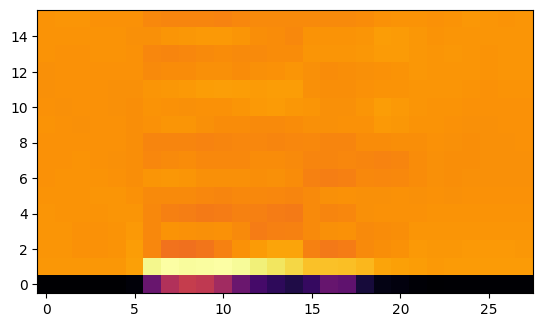

In [173]:
# TEST: Test shorter MFCC

idx = 0

# Create path from given filename and target item
# path = join(dataset_path, 
#             all_targets[int(y_orig_train[idx])], 
#             filenames_train[idx])
path = filenames_train[idx]

# Create MFCCs
mfccs = calc_mfcc(path)
print("MFCCs:", mfccs)

# Plot MFCC
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# Play wav file
print(all_targets[int(y_orig_train[idx])])
AudioSegment.from_file(path, format="wav")

In [175]:
target_list = all_targets
target_list

['on', 'off', 'up', 'down']

In [179]:
def extract_features(in_files: T.List[str], 
                     in_y: T.List[float]) -> T.List[np.ndarray]:
    """Computes a dataset of MFCC from the given input files, and associate them
    with the ground truth values.
    
    If the size of sample frames is less than the target one, then the sample 
    will be discarded.

    Args:
      in_files: list of wav files
      in_y: the ground truth values of the files in `in_files`

    Returns:
      A list of np.ndarray containing the MFCCs extracted from `in_files`
    """

    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in tqdm(enumerate(in_files), total=len(in_files)):
      
        # Create path from given filename and target item
        # path = join(dataset_path,
        #             target_list[int(in_y[index])], 
        #             filename)
        path = filename
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with the correct number of frames
        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else: 
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [183]:
print(len(filenames_train), len(y_orig_train))
print(len(filenames_val), len(y_orig_val))
print(len(filenames_test), len(y_orig_test))

12184 12184
1523 1523
1523 1523


In [184]:
# Create train, validation, and test sets

x_train, y_train, prob = extract_features(filenames_train, 
                                          y_orig_train)
print('Removed percentage:', prob / len(y_orig_train))

x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
print('Removed percentage:', prob / len(y_orig_val))

x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
print('Removed percentage:', prob / len(y_orig_test))

100%|██████████| 12184/12184 [00:33<00:00, 363.82it/s]


Removed percentage: 0.09840774786605384


100%|██████████| 1523/1523 [00:03<00:00, 428.44it/s]


Removed percentage: 0.09914642153644124


100%|██████████| 1523/1523 [00:03<00:00, 401.15it/s]

Removed percentage: 0.08667104399212082


In [185]:
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

# Model

In [186]:
# Load features

feature_sets = np.load(feature_sets_file)
feature_sets.files

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']

In [187]:
# Assign feature sets

x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [188]:
# Concatenate training and validation sets, since they will be splitted in
# stratified manner in the next steps

X = np.concatenate((x_train, x_val))
y = np.concatenate((y_train, y_val))

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (12357, 16, 28), y shape: (12357,)


In [189]:
# Number of unique labels. When the whole dataset is loaded, it should be 38.

n_labels = np.max([len(np.unique(y_test)), 
                   len(np.unique(y))])

n_labels

4

In [190]:
!mkdir models

126744.91s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [191]:
# Settings

model_filename = 'speech-commands-model.h5'
keras_model_filename = '/models/speech-commands-model.h5'
tflite_filename = '/models/speech-commands-model.tflite'

In [192]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1

x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)

X = X.reshape(X.shape[0], 
              X.shape[1], 
              X.shape[2], 
              1)

print(x_test.shape)
print(X.shape)

(1391, 16, 28, 1)
(12357, 16, 28, 1)


In [193]:
# Input shape for CNN is size of MFCC of 1 sample

input_shape = X.shape[1:]
print(input_shape)

(16, 28, 1)


In [194]:
from tensorflow.keras import layers, models, regularizers

In [206]:
def create_model(verbose: int =0):
  """Creates and build a CNN model.

  Args:
    verbose: the verbosity of the output

  Returns:
    the CNN model already complied.
  """
  # build network
  model = models.Sequential()

  # conv layer 1
  model.add(layers.Conv2D(8,
                          (3, 3), 
                          activation="relu", 
                          input_shape=input_shape))
  # conv layer 2
  model.add(layers.Conv2D(8,
                          (3, 3), 
                          activation="relu"))
  model.add(layers.MaxPool2D((2,2)))
  model.add(layers.Dropout(0.1))

  # conv layer 3
  model.add(layers.Conv2D(8,
                          (3, 3), 
                          activation="relu"))
  model.add(layers.MaxPool2D((2,2)))
  model.add(layers.Dropout(0.1))

  model.add(layers.Flatten())

  # dense layer 1
  # model.add(layers.Dense(64))
  # model.add(layers.Dropout(0.16))
  # model.add(layers.Activation("relu"))

  # dense layer 2
  model.add(layers.Dense(64))
  model.add(layers.Dropout(0.16))
  model.add(layers.Activation("relu"))

  #softmax classifier
  model.add(layers.Dense(n_labels))
  model.add(layers.Activation("softmax"))

  #compile model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(), 
      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
      metrics=["accuracy"],
  ) 

  if verbose > 0:
    model.summary()

  return model

In [208]:
def cross_validate(
    model_fn: T.Callable[[int], models.Model], 
    X: np.ndarray, 
    y: np.ndarray,
    n_splits: int = 5,
    batch_size: int = 100,
    epochs: int = 40,
    verbose: int = 0,
) -> T.Tuple[T.List[float], T.List[T.Dict]]:
  """Computes the cross validation of the input model.

  By default, it will split the input dataset in a stratified manner.

  `model_fn` should be a function that returns a keras Model, with a single 
  input parameter which specifies the verbosity.

  Args:
    model_fn: a function to create a Keras model
    X: training set
    y: labels for the training set
    n_splits: the number of folds for the stratified cross validation
    batch_size: the size of the batch during training
    epochs: the number of epochs to train the model
    verbose: the levl of verbosity

  Returns:
    A tuple with values (accuracy scores, metric histories) obtained during the
    different trainings in the folds.
  """
  
  # Hold the history of each model trained during different folds
  histories = []

  # Maximum accuracy scored during the training in each fold
  accuracy_scores = []

  # Prevent multiple printing of the model summary
  print_model = 1

  # Stratified splitter
  skf = StratifiedKFold(n_splits=n_splits)

  for fold, (train_idx, test_idx) in tqdm(
      enumerate(skf.split(X, y)), 
      total=skf.get_n_splits(),
  ):

    # Get training and test sets from the split
    X_train_, X_test_ = X[train_idx], X[test_idx]
    y_train_, y_test_ = y[train_idx], y[test_idx]

    # Create a fresh model
    model = model_fn(print_model)
    
    print_model=0

    # Train the model

    history = model.fit(X_train_,
                        y_train_,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test_, y_test_),
                        verbose=verbose,
                        callbacks=[tf.keras.callbacks.EarlyStopping(
                          monitor='val_accuracy',
                          patience=10,
                          min_delta=0.001,
                          mode='max',
                          restore_best_weights=True
                        )])


    # Save metrics 

    histories.append(history.history)
    accuracy_scores.append(np.max(history.history['val_accuracy']))
    print(f"Max validation accuracy for fold {fold}: "
          f"{np.max(history.history['val_accuracy'])}")

  return (accuracy_scores, histories)


In [199]:
def plot_metrics(history: T.Dict):
  """Plots the training history.

  The input should be the dictionary inside the History object returned by the 
  fit method of Tensorflow.

  Args: 
    history: dictionary of the history metrics of the trained model

  Returns:
    None
  """
  
  acc = history['accuracy']
  loss = history['loss']
  val_acc = history['val_accuracy']
  val_loss = history['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [209]:
# Cross validate the model

acc, hist = cross_validate(create_model, 
                           X,
                           y,
                           epochs=200, 
                           verbose=0)

  0%|          | 0/5 [00:00<?, ?it/s]WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 14, 26, 8)         80        
                                                                 
 conv2d_46 (Conv2D)          (None, 12, 24, 8)         584       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 6, 12, 8)          0         
 ng2D)                                                           
                                                                 
 dropout_60 (Dropout)        (None, 6, 12, 8)          0         
                                                                 
 conv2d_47 (Conv2D)          (None, 4, 10, 8)          584       
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 2, 5, 8)           0         
 ng2D)                                               

 20%|██        | 1/5 [00:40<02:43, 40.94s/it]WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


Max validation accuracy for fold 0: 0.9405339956283569


 40%|████      | 2/5 [01:16<01:53, 37.98s/it]WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


Max validation accuracy for fold 1: 0.9320388436317444


 60%|██████    | 3/5 [01:44<01:06, 33.41s/it]WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


Max validation accuracy for fold 2: 0.933630108833313


 80%|████████  | 4/5 [02:24<00:35, 35.86s/it]WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


Max validation accuracy for fold 3: 0.9227033853530884


100%|██████████| 5/5 [03:06<00:00, 37.37s/it]

Max validation accuracy for fold 4: 0.9429380893707275


Mean accuracy: 0.934368884563446, Max accuracy: 0.9429380893707275


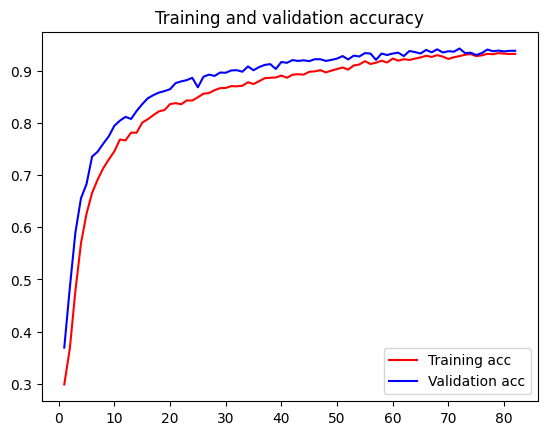

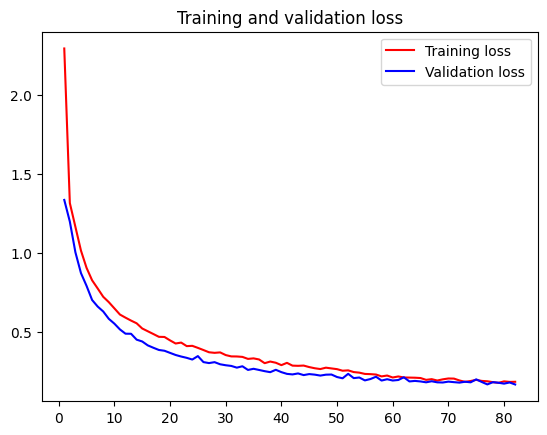

In [210]:
mean = np.mean(acc)
max = np.max(acc)
max_idx = np.argmax(acc)
print(f"Mean accuracy: {mean}, Max accuracy: {max}")
plot_metrics(hist[max_idx])

In [211]:
epochs = 100
batch_size = 100

# Store all the trained models
all_model = []

model = create_model()

history = model.fit(X, 
                    y, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                        monitor='accuracy',
                        patience=10,
                        min_delta=0.001,
                        mode='max',
                        restore_best_weights=True
                    )])

Epoch 1/100
124/124 [==============================] - 1s 4ms/step - loss: 2.5459 - accuracy: 0.2948
Epoch 2/100
124/124 [==============================] - 1s 4ms/step - loss: 1.2579 - accuracy: 0.4223
Epoch 3/100
124/124 [==============================] - 1s 4ms/step - loss: 1.0752 - accuracy: 0.5343
Epoch 4/100
124/124 [==============================] - 1s 4ms/step - loss: 0.8678 - accuracy: 0.6479
Epoch 5/100
124/124 [==============================] - 1s 4ms/step - loss: 0.7189 - accuracy: 0.7170
Epoch 6/100
124/124 [==============================] - 1s 4ms/step - loss: 0.6442 - accuracy: 0.7504
Epoch 7/100
124/124 [==============================] - 1s 4ms/step - loss: 0.5799 - accuracy: 0.7765
Epoch 8/100
124/124 [==============================] - 1s 4ms/step - loss: 0.5294 - accuracy: 0.7994
Epoch 9/100
124/124 [==============================] - 1s 4ms/step - loss: 0.4825 - accuracy: 0.8180
Epoch 10/100
124/124 [==============================] - 1s 4ms/step - loss: 0.4515 - accura

In [214]:
def plot_confusion_matrix(
    model, 
    X: np.ndarray, 
    y_true: np.ndarray, 
    labels: T.Union[str, T.List[str]] ="auto",
):
  """Computes the confusion matrix of the input model.
  
  Args:
    model: the model on which confusion matrix will be computed
    X: dataset to evalutate the model
    y_true: ground truth values of the dataset
    labels: the labels to use in the plot of the confusion matrix
    
  Returns:
    None
  """

  confusion_matrix = tf.math.confusion_matrix(
      y_true, 
      np.argmax(model.predict(X), axis=1),
  )

  plt.figure(figsize=(15,15))
  sbn.heatmap(confusion_matrix, 
              cmap='Greens', 
              xticklabels=labels, 
              yticklabels=labels)
  plt.xlabel("Prediction")
  plt.ylabel("Label")
  plt.show()

387/387 [==============================] - 0s 757us/step


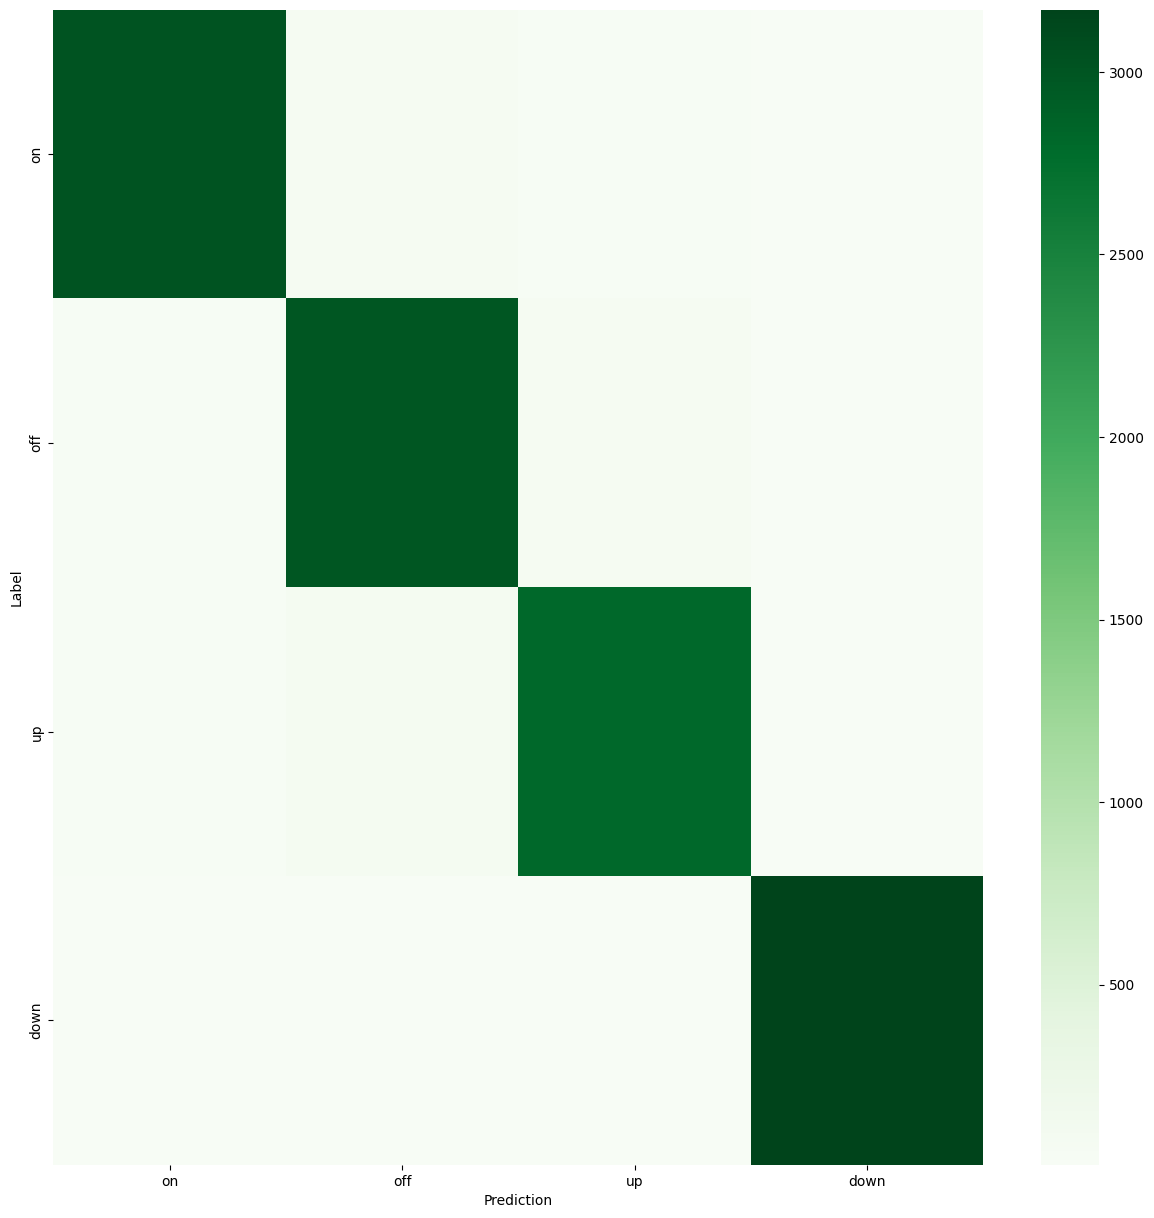

In [215]:
plot_confusion_matrix(model, X, y, labels=target_list)

In [216]:
model.evaluate(x_test, y_test)

44/44 [==============================] - 0s 988us/step - loss: 0.1487 - accuracy: 0.9432


[0.1487480252981186, 0.9432063102722168]

44/44 [==============================] - 0s 860us/step


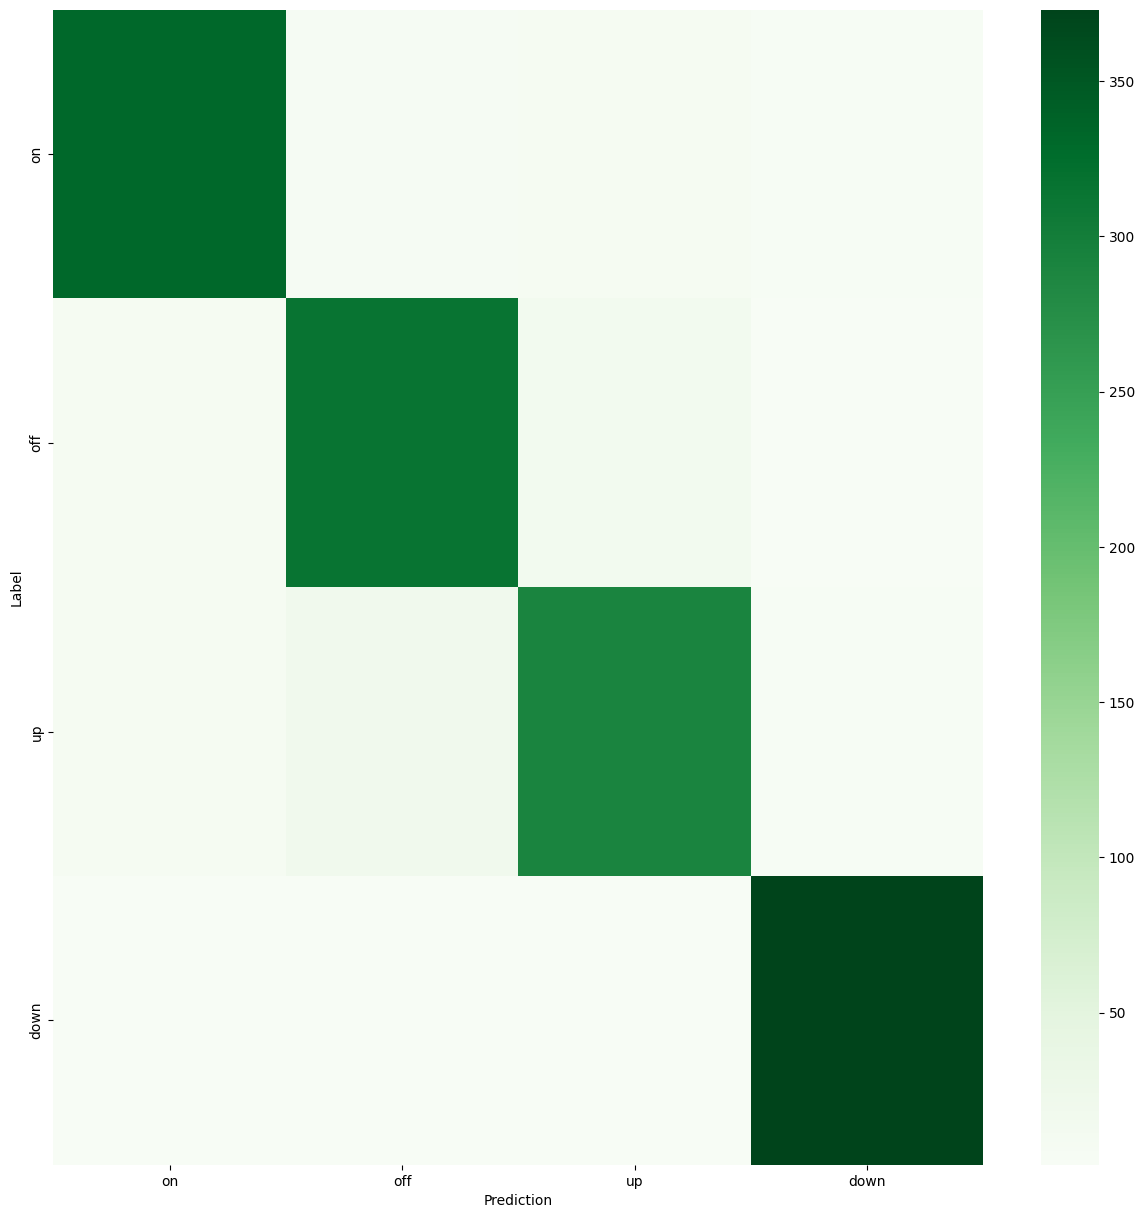

In [217]:
plot_confusion_matrix(model, x_test, y_test, labels=target_list)

In [218]:
# Save the model as a file
models.save_model(model, model_filename)

/var/folders/4j/y9g9wgxx1n7791dyt3w3vrqr0000gn/T/ipykernel_28991/4025196136.py:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  models.save_model(model, model_filename)


In [219]:
print(f"Model saved to {model_filename}")

Model saved to speech-commands-model.h5


In [220]:
# Load back the model and run it against test set

model = models.load_model(model_filename)
for i in range(100, 110):
    print('Answer:', y_test[i], ' Prediction:', np.argmax(model.predict(np.expand_dims(x_test[i], 0))))

1/1 [==============================] - 0s 37ms/step
Answer: 1  Prediction: 1
1/1 [==============================] - 0s 9ms/step
Answer: 1  Prediction: 1
1/1 [==============================] - 0s 8ms/step
Answer: 3  Prediction: 3
1/1 [==============================] - 0s 9ms/step
Answer: 1  Prediction: 1
1/1 [==============================] - 0s 9ms/step
Answer: 0  Prediction: 0
1/1 [==============================] - 0s 9ms/step
Answer: 0  Prediction: 0
1/1 [==============================] - 0s 9ms/step
Answer: 3  Prediction: 3
1/1 [==============================] - 0s 9ms/step
Answer: 0  Prediction: 0
1/1 [==============================] - 0s 9ms/step
Answer: 3  Prediction: 3
1/1 [==============================] - 0s 12ms/step
Answer: 1  Prediction: 1


In [224]:
keras_model_filename

'/models/speech-commands-model.h5'

In [227]:
# Convert model to TF Lite model

model = models.load_model('speech-commands-model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# drops by 75% the final size of the model
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

size = open('speech-commands-model.tflite', 'wb').write(tflite_model)
print(f"The model is {size / 1024} KB")

INFO:tensorflow:Assets written to: /var/folders/4j/y9g9wgxx1n7791dyt3w3vrqr0000gn/T/tmpzjsl6rhh/assets


INFO:tensorflow:Assets written to: /var/folders/4j/y9g9wgxx1n7791dyt3w3vrqr0000gn/T/tmpzjsl6rhh/assets


The model is 15.2265625 KB


2023-12-17 16:23:00.814950: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-17 16:23:00.814962: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-17 16:23:00.815113: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/4j/y9g9wgxx1n7791dyt3w3vrqr0000gn/T/tmpzjsl6rhh
2023-12-17 16:23:00.816184: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-17 16:23:00.816202: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/4j/y9g9wgxx1n7791dyt3w3vrqr0000gn/T/tmpzjsl6rhh
2023-12-17 16:23:00.818993: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-17 16:23:00.855628: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /var/folders/4j/y9g9wgxx1n7791dyt3w3vrqr0000gn/T/tmpzjsl6rhh
2023-12-

In [229]:
def test_quantized_model(
    model_path: str,
    start_idx: int,
    end_idx: int,
):
    """Loads and test the tflite model on the given indexes.
    
    Args:
      model_path: the path to the TFLite model
      start_idx: starting index to take the samples from x_test
      end_idx: ending index for x_test

    Returns:
      None
    """

    # Load the TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Test the model
    for i in range(start_idx, end_idx):
        # Load the input into the model
        input_data = np.array(np.expand_dims(x_test[i], 0), dtype=np.float32)
        interpreter.set_tensor(input_details[0]['index'], input_data)
        
        # Invoke the model on the input
        interpreter.invoke()
        
        # The function `get_tensor()` returns a copy of the tensor data.
        # Use `tensor()` in order to get a pointer to the tensor.
        output_data = interpreter.get_tensor(output_details[0]['index'])
        
        print(f'Ground truth value: {y_test[i]}\t\t'
              f'Prediction: {np.argmax(output_data)}')

In [230]:
tflite_filename = 'speech-commands-model.tflite'

In [231]:
print("Before quantization")
for i in range(100, 110):
    print('Answer:', y_test[i], ' Prediction:', np.argmax(model.predict(np.expand_dims(x_test[i], 0))))

print("After quantization")
test_quantized_model(tflite_filename, 100, 110)

Before quantization
1/1 [==============================] - 0s 40ms/step
Answer: 1  Prediction: 1
1/1 [==============================] - 0s 9ms/step
Answer: 1  Prediction: 1
1/1 [==============================] - 0s 9ms/step
Answer: 3  Prediction: 3
1/1 [==============================] - 0s 8ms/step
Answer: 1  Prediction: 1
1/1 [==============================] - 0s 9ms/step
Answer: 0  Prediction: 0
1/1 [==============================] - 0s 9ms/step
Answer: 0  Prediction: 0
1/1 [==============================] - 0s 9ms/step
Answer: 3  Prediction: 3
1/1 [==============================] - 0s 8ms/step
Answer: 0  Prediction: 0
1/1 [==============================] - 0s 9ms/step
Answer: 3  Prediction: 3
1/1 [==============================] - 0s 9ms/step
Answer: 1  Prediction: 1
After quantization
Ground truth value: 1		Prediction: 1
Ground truth value: 1		Prediction: 1
Ground truth value: 3		Prediction: 3
Ground truth value: 1		Prediction: 1
Ground truth value: 0		Prediction: 0
Ground truth va

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [236]:
!xxd -i speech-commands-model.tflite > embed_model.c

217289.16s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [237]:
!du -h embed_model.c

217311.31s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
 96K	embed_model.c
